In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as onp
import pickle

import jax
from jax import lax

from jax.api import jit, vmap, grad
# TODO: Re-enable x64 mode after XLA bug fix.
# from jax.config import config ; config.update('jax_enable_x64', True)
import warnings
warnings.simplefilter('ignore')

import jax.numpy as np

from jax import random

import optax

from jax_md import energy, space, simulate, quantity


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
from IPython import display
from functools import partial
  
sns.set_style(style='white')
sns.set(font_scale=1.6)

def format_plot(x, y):
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_facecolor('white')
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def draw_training(params):
  display.clear_output(wait=True)
  display.display(plt.gcf())
  plt.subplot(1, 2, 1)
  plt.semilogy(train_energy_error, alpha=0.5)
  plt.semilogy(test_energy_error, alpha=0.5)
  plt.xlim([0, train_epochs])
  format_plot('Epoch', '$L$')
  plt.subplot(1, 2, 2)
  predicted = vectorized_energy_fn(params, example_positions)
  plt.plot(example_energies, predicted, 'o')
  min_energy = min(example_energies.min(), predicted.min())
  max_energy = max(example_energies.max(), predicted.max())
  plot_range = np.linspace(min_energy, max_energy, 10)
  plt.plot(plot_range, plot_range, '--')
  format_plot('$E_{label}$', '$E_{prediction}$')
  finalize_plot((2, 1))
  plt.show()

In [3]:
import pandas as pd

In [4]:
from sklearn.model_selection import train_test_split
def build_dataset():
    data_gpaw = pd.read_pickle("data/gpaw_forces_dataframe.pickle")
    data_vasp = pd.read_pickle("data/VASP_MoS2_defects.pickle")
    assert (data_vasp.structures.iloc[0].lattice._matrix == data_gpaw.structure.iloc[0].cell.array).all()
    
    data_vasp.structures.iloc[0].cart_coords.shape
    
    positions = np.concatenate([i.positions[np.newaxis, :, :] for i in data_gpaw.structure] +
                               [i.cart_coords[np.newaxis, :, :] for i in data_vasp.structures], axis=0)
    energies = np.concatenate([data_gpaw.energy.values, data_vasp.energy.values])
    
    forces = np.concatenate([f[np.newaxis, :, :] for f in data_gpaw.forces] +
                            [np.zeros((len(data_vasp), positions.shape[1], positions.shape[2]))], axis=0)
    
    types = np.concatenate([i.get_atomic_numbers()[np.newaxis, :] for i in data_gpaw.structure] + 
                           [np.array(i.atomic_numbers)[np.newaxis, :] for i in data_vasp.structures], axis=0)
    return list(map(jax.numpy.array,
                    train_test_split(positions, types, energies, forces, test_size=0.25, random_state=1421))),\
           data_gpaw.structure.iloc[0].cell.array

In [5]:
(positions, test_positions, \
types, test_types, \
energies, test_energies, \
forces, test_forces), lattice = build_dataset()

energy_mean = np.mean(energies)
energy_std = np.std(energies)

print('positions.shape = {}'.format(positions.shape))
print('<E> = {}'.format(energy_mean))

positions.shape = (616, 105, 3)
<E> = -755.2579956054688


In [6]:
assert all(((types[0]==types[i]).all() for i in range(len(types))))

Next we create a space for our systems to live in using `periodic` boundary conditions.

In [7]:
#TODO(kazeevn) verify
displacement, shift = space.periodic_general(lattice.T, fractional_coordinates=False)

We can now instantiate a graph neural network using the `energy.graph_network_neighbor_list` command. This neural network is based on [recent work](https://www.nature.com/articles/s41567-020-0842-8) modelling defects in disordered solids. See that paper or the review by [Battaglia et al.](https://arxiv.org/abs/1806.01261) for details. We will add edges between all neighbors that are separated by less than a cutoff of 3 Angstroms. In JAX MD neural network potentials are specified by a triple of functions: a `neighbor_fn` that creates a list of neighbors that reside within the cutoff, an `init_fn` that initializes the parameters of the network, and an `energy_fn` that evaluates the model.

In [8]:
species = (types[0]==types[0,0]).astype(np.int32)
neighbor_fn, init_fn_gnn, energy_fn_gnn = energy.graph_network_neighbor_list(
    displacement_fn=displacement,
    nodes=np.expand_dims(species, -1).astype(np.float32),
    box_size=21,
    r_cutoff=5.9,
    dr_threshold=0.2,
    n_recurrences=2,
    mlp_sizes=(64, 64))

To start with, we construct an initial neighbor list which will be used to estimate the maximum number of neighbors. This is necessary since XLA needs to have static shapes to enable JIT compilation. See [here](https://github.com/google/jax-md#spatial-partitioning-partitionpy) for details.

In [9]:
neighbor = neighbor_fn(positions[0], extra_capacity=3)
print('Allocating space for at most {} neighbors'.format(neighbor.idx.shape[1]))

Allocating space for at most 49 neighbors


Using this neighbor prototype we will write a wrapper around our neural network energy function that will construct a neighbor list for a given state and then compute the energy. This is helpful because it allows us to use JAX's automatic vectorization via `vmap` along with our neighbor lists. Using JAX's automatic differentiation we can also write down a function that computes the force due to our neural network potential.

Note that if we were running a simulation using this energy, we would only rebuild the neighbor list when necessary.

In [10]:
@jit
def train_energy_fn(params, R):
  _neighbor = neighbor_fn(R, neighbor)
  return energy_fn_gnn(params, R, _neighbor)

# Vectorize over states, not parameters.
vectorized_energy_fn = vmap(train_energy_fn, (None, 0))

grad_fn = grad(train_energy_fn, argnums=1)
force_fn = lambda params, R, **kwargs: -grad_fn(params, R)
vectorized_force_fn = vmap(force_fn, (None, 0))

Next we will initialize the parameters of the graph network. This is done by providing the `init_fn` with a random key as well as an example input. As with the neighbor lists, this example input is used to deduce the shape of the various parameters.

In [11]:
key = random.PRNGKey(42)
params = init_fn_gnn(key, positions[0], neighbor)

Now, we can use JAX's automatic vectorization via `vmap` to compute predicted energies for all of the states using the untrained network.

In [12]:
n_predictions = 500
example_positions = positions[:n_predictions]
example_energies = energies[:n_predictions]
example_forces = forces[:n_predictions]

predicted = vmap(train_energy_fn, (None, 0))(params, example_positions)

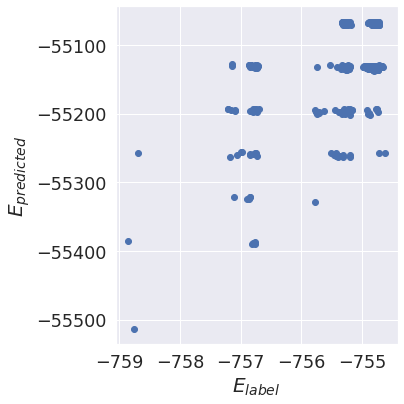

In [13]:
plt.plot(example_energies, predicted, 'o')
format_plot('$E_{label}$', '$E_{predicted}$')
finalize_plot((1, 1))

Despite the fact that the neural network is untrained we see that the outputs of the graph network correlate strongly with the labels. This hints that perhaps graph networks provide some sort of "deep molecular prior". 

Next, we define losses for the energy and the force as well as a total loss that combines the two terms. We fit both the force and the energy using Mean-Squared-Error (MSE) loss.

In [14]:
@jit
def energy_loss(params, R, energy_targets):
  return np.mean((vectorized_energy_fn(params, R) - energy_targets) ** 2)

@jit
def force_loss(params, R, force_targets):
  dforces = vectorized_force_fn(params, R) - force_targets
  return np.mean(np.sum(dforces ** 2, axis=(1, 2)))

@jit
def loss(params, R, targets):
  return energy_loss(params, R, targets[0]) + force_loss(params, R, targets[1])

Now we create an optimizer using ADAM with gradient clipping. We will also write helper functions to perform a single update step and perform an entire epochs worth of updates.

In [15]:
opt = optax.chain(optax.clip_by_global_norm(1.0),
                  optax.adam(4e-4))

@jit
def update_step(params, opt_state, R, labels):
  updates, opt_state = opt.update(grad(loss)(params, R, labels),
                                  opt_state)
  return optax.apply_updates(params, updates), opt_state

@jit
def update_epoch(params_and_opt_state, batches):
  def inner_update(params_and_opt_state, batch):
    params, opt_state = params_and_opt_state
    b_xs, b_labels = batch

    return update_step(params, opt_state, b_xs, b_labels), 0
  return lax.scan(inner_update, params_and_opt_state, batches)[0]

In [16]:
import jax

In [17]:
import optax

Finally, we will write a function that creates an epoch's worth of batches given a lookup table that shuffles all of the states in the training set.

In [18]:
dataset_size = positions.shape[0]
batch_size = 32

lookup = onp.arange(dataset_size)
onp.random.shuffle(lookup)

@jit
def make_batches(lookup):
  batch_Rs = []
  batch_Es = []
  batch_Fs = []

  for i in range(0, len(lookup), batch_size):
    if i + batch_size > len(lookup):
      break

    idx = lookup[i:i + batch_size]

    batch_Rs += [positions[idx]]
    batch_Es += [energies[idx]]
    batch_Fs += [forces[idx]]

  return np.stack(batch_Rs), np.stack(batch_Es), np.stack(batch_Fs)

batch_Rs, batch_Es, batch_Fs = make_batches(lookup)

We're now ready to train our network. We'll start by training for twenty epochs to make sure it starts training.

<Figure size 432x288 with 0 Axes>

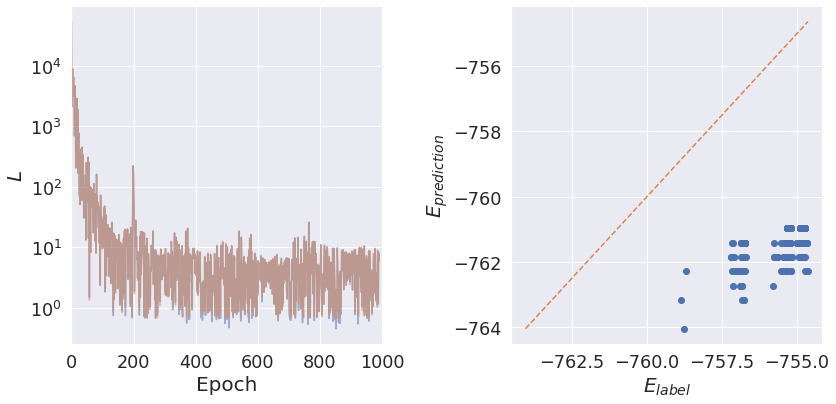

In [ ]:
train_epochs = 1000

opt_state = opt.init(params)

train_energy_error = []
test_energy_error = []

for iteration in range(train_epochs):
  # Total eV
  train_energy_error += [float(np.sqrt(energy_loss(params, batch_Rs[0], batch_Es[0])))]
  test_energy_error += [float(np.sqrt(energy_loss(params, test_positions, test_energies)))]
 
  if iteration % 10 == 0:
      draw_training(params)

  params, opt_state = update_epoch((params, opt_state), 
                                   (batch_Rs, (batch_Es, batch_Fs)))

  onp.random.shuffle(lookup)
  batch_Rs, batch_Es, batch_Fs = make_batches(lookup);

In [ ]:
np.array(test_energy_error[-20:])

We can see that final score is not so impressive and it is not stable

Now I will show you a trick to make test score more stable

In [ ]:
opt_sgd = optax.chain(optax.clip_by_global_norm(1.0), optax.sgd(1e-4))

@jit
def update_step_sgd(params, opt_state, R, labels):
  updates, opt_state = opt_sgd.update(grad(loss)(params, R, labels),
                                  opt_state)
  return optax.apply_updates(params, updates), opt_state

@jit
def update_epoch_sgd(params_and_opt_state, batches):
  def inner_update(params_and_opt_state, batch):
    params, opt_state = params_and_opt_state
    b_xs, b_labels = batch

    return update_step_sgd(params, opt_state, b_xs, b_labels), 0
  return lax.scan(inner_update, params_and_opt_state, batches)[0]

<Figure size 432x288 with 0 Axes>

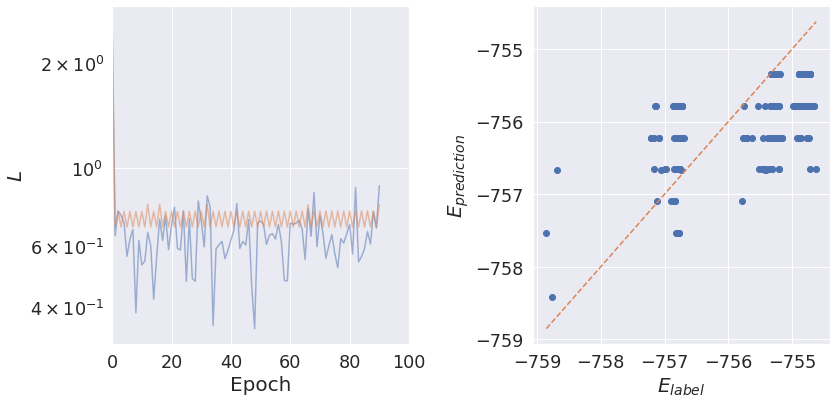

In [22]:
train_epochs = 100

opt_state = opt_sgd.init(params)

train_energy_error = []
test_energy_error = []

for iteration in range(train_epochs):
  # Total eV
  train_energy_error += [float(np.sqrt(energy_loss(params, batch_Rs[0], batch_Es[0])))]
  test_energy_error += [float(np.sqrt(energy_loss(params, test_positions, test_energies)))]
 
  if iteration % 10 == 0:
    draw_training(params)

  params, opt_state = update_epoch_sgd((params, opt_state), 
                                   (batch_Rs, (batch_Es, batch_Fs)))

  onp.random.shuffle(lookup)
  batch_Rs, batch_Es, batch_Fs = make_batches(lookup)

After Adam optimizer we add a few steps of SGD optimizer and results become much better and more stable. It is significant improvement.

In [23]:
np.array(test_energy_error[-20:])

DeviceArray([0.75426686, 0.67859185, 0.7543303 , 0.67858493, 0.75440466,
             0.67857045, 0.7544686 , 0.67857736, 0.7545581 , 0.6785641 ,
             0.7848102 , 0.67855847, 0.754682  , 0.6785462 , 0.75476813,
             0.6785295 , 0.78457654, 0.67853457, 0.75488335, 0.67851657],            dtype=float32)

In [24]:
with open("gnn-wide.pkl", "wb") as params_file:
    pickle.dump(params, params_file)

Using our trained model we plot the predicted energies and forces against the labels. 